In [52]:
import os
import numpy as np
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
import matplotlib.pyplot as plt
import gc
%matplotlib inline

from util import *

In [2]:
cache_dir = "./cache" # path to the cache directory

# create the cache directory if it doesn't exist
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge", cache_dir=cache_dir).to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge", cache_dir=cache_dir)

Image size: (1644, 1144)


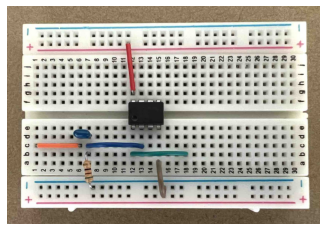

In [19]:
img_path = "images/simple.jpg"
raw_image = Image.open(img_path).convert("RGB")

# print image size
print("Image size: {}".format(raw_image.size))

# display the image
plt.imshow(raw_image)
plt.axis("off")
plt.show()

# coordinates are (67, 62) and (590, 407)
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

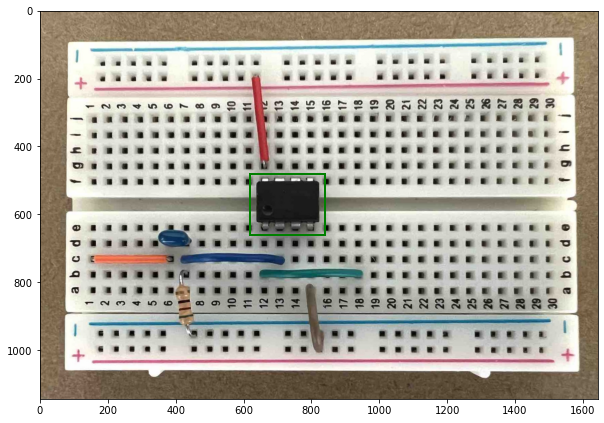

In [21]:
input_boxes = [[620, 480, 840, 660]]
show_boxes_on_image(raw_image, input_boxes)

In [40]:
inputs = processor(raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

tensor([[[0.9600, 0.9782, 0.9822]]])


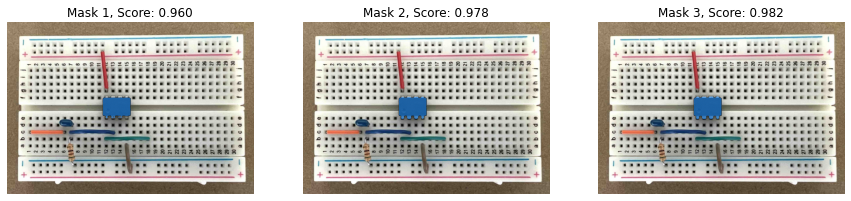

In [41]:
print(scores)
show_masks_on_image(raw_image, masks[0], scores)

Number of true elements in the mask: 23438
Center of the mask: [565.23350969 729.11152829]
Number of true elements in the mask: 24951
Center of the mask: [567.5582141  729.72766623]
Number of true elements in the mask: 25550
Center of the mask: [567.23471624 729.62618395]


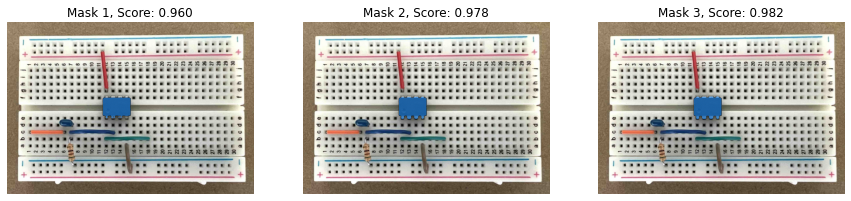

In [46]:
inputs = processor(raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

masks = masks[0]

if len(masks.shape) == 4:
    masks = masks.squeeze()
if scores.shape[0] == 1:
    scores = scores.squeeze()

nb_predictions = scores.shape[-1]
fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

for i, (mask, score) in enumerate(zip(masks, scores)):
    mask = mask.cpu().detach()
    axes[i].imshow(np.array(raw_image))
    # mask to numpy array
    mask = mask.numpy()
    # compute the number of true elements in the mask
    nb_true = np.sum(mask)
    print("Number of true elements in the mask: {}".format(nb_true))
    # get coordinates of the true elements
    coords = np.argwhere(mask == 1)
    # compute the center of the mask
    center = np.mean(coords, axis=0)
    print("Center of the mask: {}".format(center))
    show_mask(mask, axes[i])
    axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
    axes[i].axis("off")
plt.show()

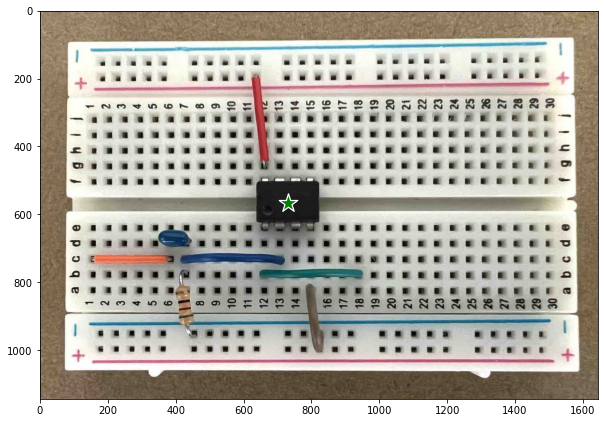

In [50]:
pt = [567.23471624, 729.62618395]
pt = pt[::-1]
show_points_on_image(raw_image, [pt])

In [59]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

In [54]:
from transformers import pipeline
generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=device)

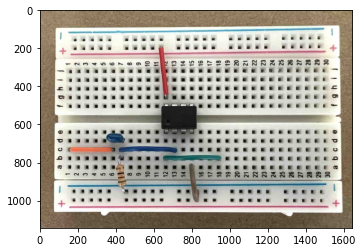

In [55]:
plt.imshow(raw_image)

In [56]:
outputs = generator(raw_image, points_per_batch=64)

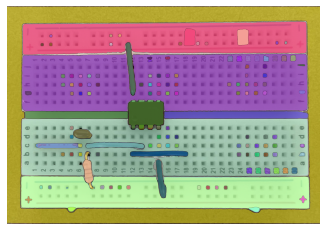

In [65]:
masks = outputs["masks"]
show_masks_on_image(raw_image, masks)

In [61]:
# compute average size of the masks
avg_size = np.mean([np.sum(mask) for mask in masks])
print("Average size of the masks: {}".format(avg_size))


Average size of the masks: 20503.85714285714


In [66]:
# compute size of the smallest mask
min_size = np.min([np.sum(mask) for mask in masks])
print("Size of the smallest mask: {}".format(min_size))

Size of the smallest mask: 183


In [64]:
len(masks)

13

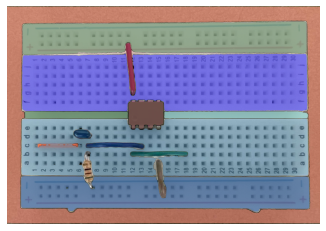

In [62]:
# show the masks with a size greater than the average size
masks = [mask for mask in masks if np.sum(mask) > avg_size]
show_masks_on_image(raw_image, masks)